# Clustering et word2vec

Sur la base des éléments méthodologiques et des enseignements techniques présentés lors du cours théorique, il est demandé dans le cadre de ce TP :
- d’effectuer un clustering des bulletins pour une décennie au choix et d’interpréter les résultats
- d’entraîner un modèle word2vec sur l’ensemble des bulletins et d’explorer les relations entre vecteurs

Pour ce faire, vous utiliserez différentes librairies Python vues au cours comme scikit-learn et gensim.

#### Librairies nécessaires

In [8]:
import collections
import os
import string
import sys

import pandas as pd

import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode

from pprint import pprint

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 1. Clustering

#### Choisir une décénie et charger les fichiers

In [103]:
data_path = "../data/txt/"

In [104]:
DECADE = '1880'

In [105]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [106]:
# vérifier les fichiers
files[:5]

['Bxl_1880_Tome_I1_Part_1.txt',
 'Bxl_1880_Tome_I1_Part_10.txt',
 'Bxl_1880_Tome_I1_Part_2.txt',
 'Bxl_1880_Tome_I1_Part_3.txt',
 'Bxl_1880_Tome_I1_Part_4.txt']

In [107]:
texts = [open(data_path + f).read() for f in files]

In [108]:
# explorer un texte
texts[0][:400]

'VILLE\n\nD E\n\nBULLETIN\n\nBRUXELLES.\n\nCOMMUNAL\n\nA N N É E\n\n1880.\n\nPREMIÈRE PARTIE.\n\nCOMPTE\n\nRENDU\n\nDES\n\nSÉANCES.\n\nBBUXELLES,\n\nIMPRIMERIE DE V JULIEN BAERTSOEN,\nGrand\'Place, 5.\ne\n\n\x0c]\n\nI\n\n£\n\ni\n\n!\n\n\x0cN " 1.\n\nCOMPTE RENDU DE LA SÉANCE DÛ 1 2 JANVIER 1 8 8 0 .\n\nVILLE\n\nDE\n\nBRUXELLES.\n\nBULLETIN\n\nC O M M U N A L\n\nANNÉE\n\nC O N S E I L\n\n1880.\n\nC O M M U N A L .\n\nSéance du 42 Janvier 1880.\nPrésidence de M . F . V'

#### Vectoriser les fichiers

In [109]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

In [110]:
# instancier le modèle
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

In [111]:
# construire la matrice
%time tfidf_vectors = vectorizer.fit_transform(texts)

CPU times: user 2min 29s, sys: 48.9 ms, total: 2min 29s
Wall time: 2min 29s


In [113]:
# vecteur du premier document
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

delecosse        0.338644
délégation       0.206433
trappeniers      0.199561
veldekens        0.179754
monte-charges    0.172713
                   ...   
dépense.+m       0.000000
dépense+de       0.000000
dépens           0.000000
dépendances      0.000000
••               0.000000
Length: 7997, dtype: float64

In [114]:
# transfert vers un tableau pour effectuer des tests
tfidf_array = tfidf_vectors.toarray()

In [115]:
cosine(tfidf_array[0], tfidf_array[1])

0.9012494794236015

#### Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

In [116]:
N_CLUSTERS = 6

#### Instancier le modèle K-Means et ses arguments

In [117]:
km_model = KMeans(n_clusters=N_CLUSTERS, random_state = 42)

#### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [118]:
clusters = km_model.fit_predict(tfidf_vectors)

In [119]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

#### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA

In [121]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

### Générer le plot

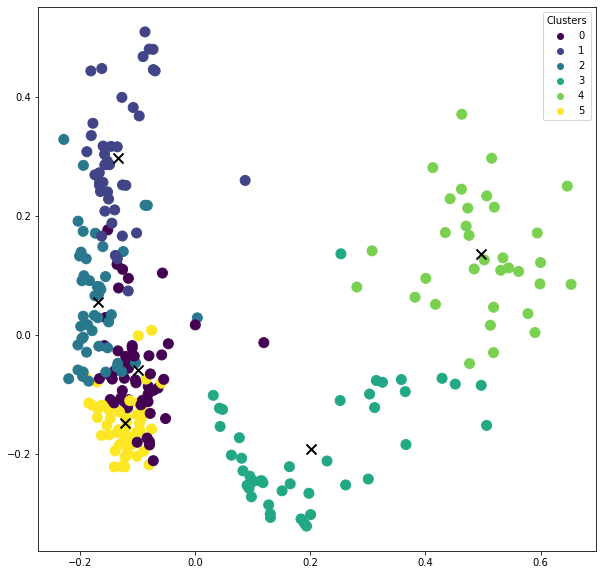

In [123]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

#### Sélection des fichiers de Bruxelles, uniquement

In [124]:
files = [f for f in sorted(os.listdir(data_path)) if f"Bxl_{DECADE[:-1]}" in f]

In [125]:
texts = [open(data_path + f).read() for f in files]

In [126]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

In [127]:
%time tfidf_vectors = vectorizer.fit_transform(texts)

CPU times: user 1min 46s, sys: 2.55 ms, total: 1min 46s
Wall time: 1min 46s


#### Générer le plot sur base du clustering

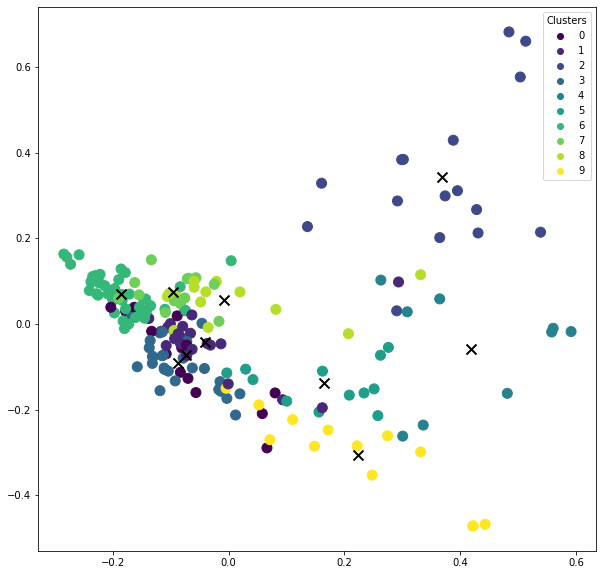

In [134]:
N_CLUSTERS = 10

#instancier le modèle KMeans
km_model = KMeans(n_clusters=N_CLUSTERS, random_state = 42)

# appliquer le clustering
clusters = km_model.fit_predict(tfidf_vectors)

clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

# réduire les dimensions
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

# générer le plot
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

In [135]:
pprint(dict(clustering))

{0: ['Bxl_1882_Tome_I2_Part_2.txt',
     'Bxl_1882_Tome_I2_Part_4.txt',
     'Bxl_1882_Tome_I2_Part_8.txt',
     'Bxl_1883_Tome_I1_Part_1.txt',
     'Bxl_1883_Tome_I2_Part_3.txt',
     'Bxl_1883_Tome_I2_Part_7.txt',
     'Bxl_1884_Tome_I2_Part_1.txt',
     'Bxl_1884_Tome_I2_Part_6.txt',
     'Bxl_1885_Tome_I1_Part_2.txt',
     'Bxl_1885_Tome_I2_Part_8.txt',
     'Bxl_1886_Tome_I1_Part_3.txt',
     'Bxl_1886_Tome_I2_Part_1.txt',
     'Bxl_1887_Tome_I1_Part_1.txt',
     'Bxl_1887_Tome_I1_Part_2.txt',
     'Bxl_1887_Tome_I2_Part_2.txt'],
 1: ['Bxl_1881_Tome_I2_Part_5.txt',
     'Bxl_1881_Tome_I2_Part_6.txt',
     'Bxl_1882_Tome_I2_Part_5.txt',
     'Bxl_1882_Tome_I2_Part_6.txt',
     'Bxl_1883_Tome_I2_Part_10.txt',
     'Bxl_1883_Tome_I2_Part_4.txt',
     'Bxl_1883_Tome_I2_Part_5.txt',
     'Bxl_1883_Tome_I2_Part_6.txt',
     'Bxl_1884_Tome_I1_Part_3.txt',
     'Bxl_1884_Tome_I2_Part_3.txt',
     'Bxl_1884_Tome_I2_Part_4.txt',
     'Bxl_1884_Tome_I2_Part_5.txt',
     'Bxl_1885_Tome_I2_Par

Il est difficile de juger de la pertinence des clusters sur un si grand nombre de fichiers. Dans le cas de cette décennie (1880), la dipsersion est telle qu'un certain nombre de fichiers sont ramassés sur la gauche, tandis que le reste se distribue plus largement. Un nettoyage des fichiers plus poussé permettrait sans doute de "rééquilibrer" la distribution afin d'obtenir des clusters plus marqués.

Cependant, cette technique de clustering représente un intérêt pour classer les fichiers entre eux afin d'explorer des "thématiques" communes sur base de la fréquence des mots de l'ensemble étudié. En rassemblant les fichiers et les traitant à l'aide de fonctions de nettoyage plus poussées, il sera sans doute plus facile d'éliminer des mots fréquents de l'ensemble des "paquets" afin d'explorer plus finement le contenu. Des listes de stopwords peuvent être consitutées en fonction des clusters et ainsi permettre de faire ressortir du contenu plus informationnel.

Pour vérifier la méthode, il faudrait pouvoir explorer les contenus de manière plus aisée, en procédant par exemple à des wordclouds ou en extrayant les keywords pour chacun des clusters.

## 2. Word2Vec

Avant de procéder à l'amélioration du modèle en appliquant successivement les fonctions bigrammes/trigrammes/quadrigrammes/pentagrammes, j'ai d'abord porcédé à l'exploration de différents caractéristiques déterminant la qualité des modèles. Le tableau ci-dessous reprend les résultats obtenus pour les mêmes requêtes. Celles-ci sont calquées sur celles présentées au cours.

Le modèle 1 est celui fourni à la base et appliqué à une partie du corpus (fichier 'sents' créé à l'aide du notebook du cours). Tous les autres modèles se basent sur le fichier de Max De Wilde, renommé en 'sents_2'. J'ai ensuite fait varier la taille du vecteur (32, 100 ou 300), la taille de la fenêtre (5, 7, 10, 13, 20, 40), la fréquence minimale des mots, le nombre de 'workers' et les 'epochs'. Ceci m'a permis d'approcher les différences en fonction de requêtes similaires appliquées à l'ensemble des modèles. 

Mes principales constations sont que le nombre d''epochs' semble améliorer les performances des modèles quelque soit la taille du vecteur. Le nombre de 'workers' semble diminuer la précision des modèles. La taille du vecteur et de la fenêtre augmentent la sensibilité des modèles ; ils semblent devenir plus "sensibles", plus "subtiles" mais peut-être moins "précis". Ainsi, avec une vecteur de 100 et une fenêtre de 7, le modèle parvient à comprendre que le charcutier est au plus proche du boucher, que les autres métiers généralement renseignés. Remarquons qu'avec un vecteur de 300, il faut élargir la taille du vecteur à 13 pour parvenir à un tel résultat.

J'opte donc a priori pour des modèles dont la taille de la fenêtre augmente en fonction de la taille du vecteur. Cependant, il faudra voir si l'application plus poussée des fonctions du Phraser ne viendra pas perturber ces résultats.

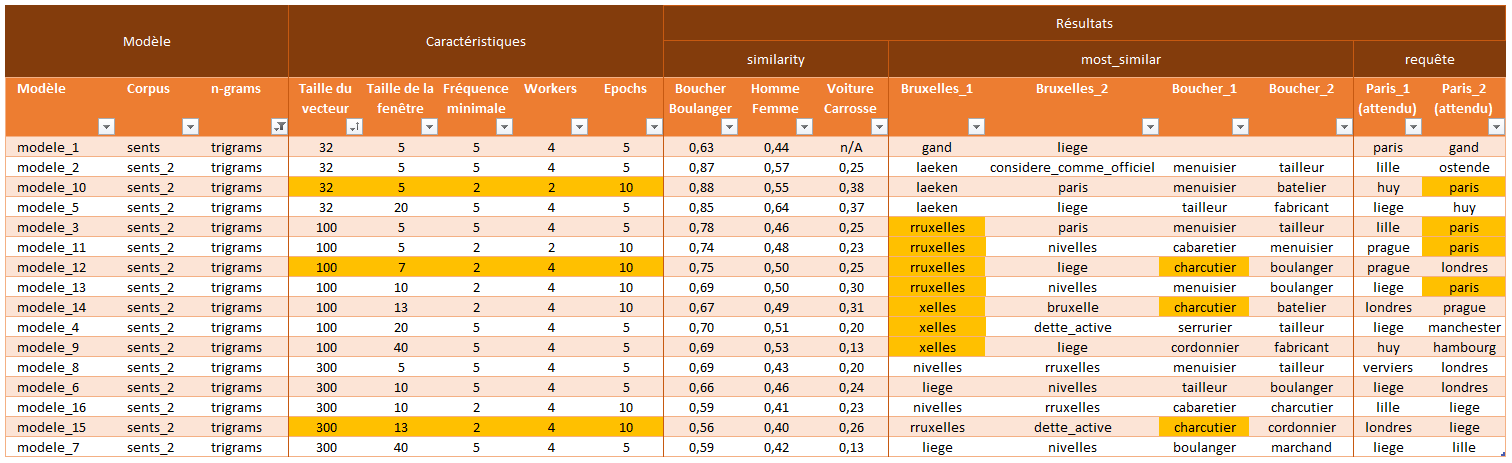

Tous les résultats sont disponibles dans le repo du module 4, dans les deux forks du notebook pour le word embeddings.

#### Chargement des phrases

In [136]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [137]:
infile = f"../data/sents_2.txt"

In [138]:
sentences = MySentences(infile)

#### Création des bigrammes

In [139]:
bigram_phrases = Phrases(sentences)

In [140]:
len(bigram_phrases.vocab.keys())

5978799

In [144]:
%time bigram_phrases[sentences]

CPU times: user 3 ms, sys: 43 µs, total: 3.04 ms
Wall time: 5.91 ms


In [145]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

In [146]:
%time bigram_phraser[sentences]

CPU times: user 3.45 ms, sys: 49 µs, total: 3.5 ms
Wall time: 2.88 ms


In [147]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [148]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

In [149]:
quadrigram_phrases = Phrases(trigram_phraser[sentences])

In [150]:
quadrigram_phraser = Phraser(phrases_model=quadrigram_phrases)

In [151]:
pentagram_phrases = Phrases(quadrigram_phraser[sentences])

In [152]:
pentagram_phraser = Phraser(phrases_model=pentagram_phrases)

In [153]:
corpus = list(pentagram_phraser[quadrigram_phraser[trigram_phraser[bigram_phraser[sentences]]]])

In [16]:
print(corpus[:10])

[['v', 'i', 'l', 'l', 'e', 'de', 'bruxelles', 'bulletin', 'ires', '8eanas', 'dl', '!'], ['conseil_communal', 'annee', '1847', '.'], ['au', 'ville', 'de', 'b', 'r', 'u', 'x', 'e', 'l', 'l', 'e', 's', '.'], ['bulletin', 'conseil', 'aes', 'seances', 'communal', '.'], ['annee', '1847', '.'], ['bruxelles', ',', 'imprimerie', 'd', 'e', 'j', '.'], ['h', '.', 'b', 'r', 'i', 'a', 'r', 'd', ',', 'rite', 'n', 'e', 'u', 'v', 'e', ',', '3', '1', ',', 'faubourg', 'de', 'n', 'a', 'm', 'u', 'r', ',', '1', '84', '8', 'de', '!'], ['du', 'consei', 'dibi', 'e', '.', '-', 'communication', 'conclusions', 'de', 'la', 'section', 'des', 'du', 'nouvel_hospice', 'pour', 'les', 'av', 'enraisonde', 'l', "'", 'absence', '&', 'maladie', '.', 'le', 'conseil', 'ajourne', 'leurs', 'de', 'pierre', 'el', 'marchai', 'cles', 'des', 'taxes', 'communale', "'", 'bieniaance', 'eldeseianv', 'il', 'est', 'donne', 'communie', ';', 'mandant', 'le', 'o', 'p', 'fa', 'gnant', 'l', "'", 'envoi', 'de', 'leur', 'bn', 'par', 'l', "'", 'e

#### Modèle 1 du tp3 (300-10)

In [23]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=300, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=10, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=2, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=10 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

CPU times: user 2h 20min 49s, sys: 9min 36s, total: 2h 30min 25s
Wall time: 44min 14s


In [24]:
# outfile = f"../data/bulletins_tp3_1.model"
# model.save(outfile)

In [34]:
model = Word2Vec.load("../data/bulletins_tp3_1.model")

#### Exploration du modèle

In [5]:
model.wv.similarity("boucher", "boulanger")

0.57089794

In [30]:
model.wv.similarity("homme", "femme")

0.42860717

In [22]:
model.wv.similarity("voiture", "carrosse")

0.28735888

In [25]:
model.wv.similarity("voiture", "chien")

0.42339402

In [6]:
model.wv.most_similar("bruxelles", topn=10)

[('rruxelles', 0.5818007588386536),
 ('nivelles', 0.5182838439941406),
 ('liege', 0.5148740410804749),
 ('bruxeles', 0.4937210977077484),
 ('bruxelle', 0.4917224645614624),
 ('jrvice', 0.471939355134964),
 ('xelles', 0.4709879159927368),
 ('huy', 0.47084033489227295),
 ('prague', 0.46914100646972656),
 ('binche', 0.46828752756118774)]

In [35]:
model.wv.most_similar("boucher", topn=10)

[('charcutier', 0.5995927453041077),
 ('boulanger', 0.5708979368209839),
 ('tailleur', 0.5652803778648376),
 ('cabaretier', 0.5632399320602417),
 ('cordonnier', 0.5628831386566162),
 ('abatteur', 0.5618293285369873),
 ('coiffeur', 0.5468771457672119),
 ('marchand', 0.5446248650550842),
 ('serrurier', 0.5419819951057434),
 ('fabricant', 0.5392330884933472)]

In [27]:
model.wv.most_similar("platonisme", topn=10)

[('aristotelisme', 0.8893957734107971),
 ('symbolis', 0.8818884491920471),
 ('centum', 0.8812199831008911),
 ('christiano', 0.879470705986023),
 ('147437', 0.8793374300003052),
 ('66637', 0.8787049055099487),
 ('153125', 0.8774873614311218),
 ('gewidmet', 0.8770879507064819),
 ('43451', 0.8768373727798462),
 ('122571', 0.8763118982315063)]

In [7]:
print(model.wv.most_similar(positive=['bruxelles', 'france'], negative=['belgique']))

[('liege', 0.5035298466682434), ('londres', 0.494385689496994), ('milan', 0.48436862230300903), ('tournai', 0.47917115688323975), ('huy', 0.4791364371776581), ('verviers', 0.470472127199173), ('prague', 0.4691561460494995), ('ostende', 0.46747785806655884), ('hambourg', 0.4582105278968811), ('paris', 0.4556889533996582)]


In [ ]:
print(model.wv.most_similar(positive=['bruxelles', 'espagne'], negative=['belgique']))

In [ ]:
print(model.wv.most_similar(positive=['bruxelles', 'allemagne'], negative=['belgique']))

In [ ]:
print(model.wv.most_similar(positive=['bruxelles', 'italie'], negative=['belgique']))

In [ ]:
print(model.wv.most_similar(positive=['bruxelles', 'russie'], negative=['belgique']))

In [18]:
print(model.wv.most_similar(positive=['roi', 'femme'], negative=['homme']))

[('mere', 0.4184131324291229), ('eoi', 0.4026956558227539), ('boi', 0.39582201838493347), ('fille', 0.3846323490142822), ('famille_royale', 0.3765176236629486), ('eclale', 0.37051498889923096), ('zeepaard', 0.3684881925582886), ('sieur_van_eesbeeck', 0.36782413721084595), ('mgr', 0.3621143698692322), ('princesse_marie', 0.35621941089630127)]


In [15]:
print(model.wv.most_similar(positive=['fidelite', 'homme'], negative=['femme']))

[('obeissance', 0.538389265537262), ('<<_je_jure', 0.5057224631309509), ('je_jure_fidelite', 0.4389154016971588), ('inalterableattachement', 0.4325920641422272), ('hommage_particulier', 0.4223836660385132), ('peuple_belge', 0.42071980237960815), ('desinteressement', 0.4178043603897095), ('serment_suivant', 0.41470056772232056), ('serment', 0.4126855134963989), ('juste_hommage', 0.4065362513065338)]


In [31]:
print(model.wv.most_similar(positive=['fidelite', 'femme'], negative=['homme']))

[('<<_je_jure', 0.5098984241485596), ('obeissance', 0.5080048441886902), ('je_jure_fidelite', 0.46494928002357483), ('serment_suivant', 0.409962922334671), ('jure_fidelite', 0.4073270559310913), ('famille_royale', 0.406828373670578), ('serment_constitutionnel', 0.4066757559776306), ('respectueuse_expression', 0.4052557945251465), ('victoire', 0.3968193829059601), ('liberte_absolue', 0.3927416503429413)]


In [ ]:
print(model.wv.most_similar(positive=['urinoir', 'femme'], negative=['homme']))

[('fenetre', 0.5346331000328064), ('mansarde', 0.5246878862380981), ('cloison', 0.520297110080719), ('terrasse', 0.5074345469474792), ('loge', 0.5059982538223267), ('douche', 0.49894893169403076), ('cave', 0.49847882986068726), ('chaudiere', 0.49798569083213806), ('pouponniere', 0.4923699200153351), ('laverie', 0.4922226071357727)]


In [ ]:
print(model.wv.most_similar(positive=['enfant', 'homme'], negative=['femme']))

[('individu', 0.5726050138473511), ('artiste', 0.5208781361579895), ('honnete_homme', 0.5015160441398621), ('elan', 0.4846319854259491), ('jeune_homme', 0.48355039954185486), ('instrument', 0.4822431802749634), ('seul_homme', 0.47085273265838623), ('quelqu', 0.4698927104473114), ('homme_politique', 0.4673098027706146), ('ecrivain', 0.46418407559394836)]


In [ ]:
print(model.wv.most_similar(positive=['enfant', 'femme'], negative=['homme']))

[('mere', 0.5782514810562134), ('fille', 0.5571849346160889), ('jeune_fille', 0.522800624370575), ('maman', 0.5204247236251831), ('servante', 0.5070370435714722), ('fillette', 0.497027724981308), ('pensionnaire', 0.4956570565700531), ('orpheline', 0.4850376546382904), ('soeur', 0.48322024941444397), ('leurs_parents', 0.48130083084106445)]


#### Modèle 2 du tp3 (32-10)

In [22]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=10, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=2, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=10 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

CPU times: user 40min 4s, sys: 1min 51s, total: 41min 56s
Wall time: 14min 27s


In [23]:
# outfile = f"../data/bulletins_tp3_2.model"
# model.save(outfile)

In [24]:
model = Word2Vec.load("../data/bulletins_tp3_2.model")

In [25]:
model.wv.similarity("boucher", "boulanger")

0.8609588

In [26]:
model.wv.similarity("homme", "femme")

0.62290215

In [27]:
model.wv.similarity("voiture", "carrosse")

0.41236758

In [28]:
model.wv.similarity("voiture", "chien")

0.5687413

In [29]:
model.wv.most_similar("bruxelles", topn=10)

[('laeken', 0.8323514461517334),
 ('liege', 0.7878617644309998),
 ('nivelles', 0.7507333755493164),
 ('cantonnale', 0.7505260705947876),
 ('gand', 0.7435848116874695),
 ('mons', 0.7311862111091614),
 ('paris', 0.7162811756134033),
 ('rruxelles', 0.714896559715271),
 ('flandres', 0.7096958160400391),
 ('aux_confins', 0.7072545886039734)]

In [30]:
model.wv.most_similar("boucher", topn=10)

[('batelier', 0.8890909552574158),
 ('charcutier', 0.8885161876678467),
 ('macon', 0.8633956909179688),
 ('boulanger', 0.8609588742256165),
 ('menuisier', 0.8580062389373779),
 ('marchand', 0.8434250950813293),
 ('terrassier', 0.8390104174613953),
 ('cabaretier', 0.8362985253334045),
 ('tailleur', 0.8337821960449219),
 ('poissonnier', 0.8302710652351379)]

In [31]:
model.wv.most_similar("platonisme", topn=10)

[('beveiligen', 0.9539734721183777),
 ('kundig', 0.9495147466659546),
 ('lnventaris', 0.949018120765686),
 ('onze_maatschappij', 0.9476034045219421),
 ('haare', 0.9474144577980042),
 ('jser', 0.9442475438117981),
 ('haupt', 0.9437791109085083),
 ('ontduiking', 0.941407322883606),
 ('***>', 0.9412257075309753),
 ('efdael', 0.9409153461456299)]

In [32]:
print(model.wv.most_similar(positive=['bruxelles', 'france'], negative=['belgique']))

[('huy', 0.8370460271835327), ('ostende', 0.8271083235740662), ('verviers', 0.8080962300300598), ('gand', 0.8075035810470581), ('liege', 0.8056627511978149), ('lille', 0.7857369184494019), ('paris', 0.7746098637580872), ('louvain', 0.7729559540748596), ('flandres', 0.7717507481575012), ('alost', 0.7653114199638367)]


In [33]:
print(model.wv.most_similar(positive=['roi', 'femme'], negative=['homme']))

[('sieur_van_eesbeeck', 0.6661351323127747), ('messe_quotidienne', 0.6570274829864502), ('annep', 0.6544880867004395), ('brabant', 0.6392697095870972), ('dansante_sera', 0.6349672675132751), ('letttre', 0.6327504515647888), ('messe_solennelle', 0.6322498321533203), ('septembre_1949', 0.6276273131370544), ('congregation', 0.6272263526916504), ('unifamiliale', 0.6266288161277771)]


In [34]:
print(model.wv.most_similar(positive=['fidelite', 'homme'], negative=['femme']))

[('<<_je_jure', 0.8076946139335632), ('serment_suivant', 0.7857425808906555), ('cartel', 0.7674791812896729), ('verbe', 0.754385232925415), ('respect', 0.7543176412582397), ('mepris', 0.7468379139900208), ('je_jure_fidelite', 0.7452432513237), ('obeissance', 0.7366427183151245), ('peuple_belge', 0.7356619238853455), ('communisme', 0.7327820658683777)]


In [35]:
print(model.wv.most_similar(positive=['fidelite', 'femme'], negative=['homme']))

[('famille_royale', 0.739972710609436), ('suspension_entraine', 0.7090593576431274), ('commission_paritaire', 0.701867401599884), ('liberte_individuelle', 0.6872615814208984), ('reponse_donnee', 0.6771332025527954), ('liste_portait', 0.6767422556877136), ('elle_commettrait', 0.6667153835296631), ('prefecture', 0.6665677428245544), ('circonscription_militaire', 0.6577958464622498), ('libre_concurrence', 0.6552494168281555)]


In [ ]:
print(model.wv.most_similar(positive=['urinoir', 'femme'], negative=['homme']))

[('mansarde', 0.8571958541870117), ('cave', 0.8542822003364563), ('terrasse', 0.8352386355400085), ('glaciere', 0.8255090117454529), ('baignoire', 0.8180697560310364), ('chaudiere', 0.8113610148429871), ('cloison', 0.8081401586532593), ('cloison_vitree', 0.8068118095397949), ('tremie', 0.8022738695144653), ('dalle', 0.7997750639915466)]


In [ ]:
print(model.wv.most_similar(positive=['enfant', 'homme'], negative=['femme']))

[('outil', 0.8101339340209961), ('instrument', 0.7956112027168274), ('ecrivain', 0.7922137975692749), ('condisciple', 0.7866582870483398), ('interet_particulier', 0.7811781764030457), ('tremplin', 0.7791550159454346), ('elan', 0.7758635878562927), ('compagnon', 0.7740587592124939), ('desinteressement', 0.7727602124214172), ('honnete_homme', 0.767368495464325)]


In [ ]:
print(model.wv.most_similar(positive=['enfant', 'femme'], negative=['homme']))

[('fillette', 0.7821374535560608), ('leur_mere', 0.776722252368927), ('fille', 0.7731388807296753), ('classe_flamande', 0.7696354985237122), ('maman', 0.768470823764801), ('carte_medicale', 0.7680832743644714), ('vaccine', 0.7643815279006958), ('incapacite', 0.7630890607833862), ('jeune_fille', 0.7610793113708496), ('servante', 0.7577486038208008)]


#### Modèle 3 du tp3 (100-10)

In [17]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=100, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=10, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=2, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=10 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

CPU times: user 58min 2s, sys: 2min 48s, total: 1h 50s
Wall time: 20min 13s


In [18]:
# outfile = f"../data/bulletins_tp3_3.model"
# model.save(outfile)

In [56]:
model = Word2Vec.load("../data/bulletins_tp3_3.model")

In [20]:
model.wv.similarity("boucher", "boulanger")

0.698616

In [21]:
model.wv.similarity("homme", "femme")

0.495938

In [57]:
model.wv.similarity("homme", "individu")

0.7249576

In [59]:
model.wv.similarity("bon", "mechant")

0.31609356

In [60]:
model.wv.similarity("beau", "vilain")

0.3810237

In [63]:
model.wv.similarity("noir", "blanc")

0.84282684

In [22]:
model.wv.similarity("voiture", "carrosse")

0.40252274

In [23]:
model.wv.similarity("voiture", "chien")

0.50289965

In [24]:
model.wv.most_similar("bruxelles", topn=10)

[('bruxelle', 0.6584612131118774),
 ('rruxelles', 0.6331698298454285),
 ('nivelles', 0.6230177879333496),
 ('liege', 0.6171610355377197),
 ('manufacturiere', 0.6123355031013489),
 ('xelles', 0.606942355632782),
 ('franconat', 0.5970131158828735),
 ('jumeaux_naissances', 0.5757424235343933),
 ('paris', 0.5751731395721436),
 ('lille_1860', 0.5711173415184021)]

In [25]:
model.wv.most_similar("boucher", topn=10)

[('cabaretier', 0.7270393967628479),
 ('charcutier', 0.7228695750236511),
 ('cordonnier', 0.7149555683135986),
 ('batelier', 0.7027667760848999),
 ('abatteur', 0.6987067461013794),
 ('boulanger', 0.6986159682273865),
 ('tailleur', 0.6906746625900269),
 ('coiffeur', 0.6878450512886047),
 ('serrurier', 0.6874961853027344),
 ('menuisier', 0.6871436834335327)]

In [26]:
model.wv.most_similar("platonisme", topn=10)

[('nnick', 0.9197626113891602),
 ('maison_hoguet', 0.9195288419723511),
 ('schakel', 0.9170469045639038),
 ('orfeo', 0.9167062044143677),
 ('osmometre', 0.9142835140228271),
 ('enseignement_moyencomm', 0.912686824798584),
 ('georges_jamin', 0.9122795462608337),
 ('schra', 0.911679208278656),
 ('lepevre', 0.9116352200508118),
 ('shoren', 0.9113874435424805)]

In [27]:
print(model.wv.most_similar(positive=['bruxelles', 'france'], negative=['belgique']))

[('paris', 0.6425924897193909), ('huy', 0.6266448497772217), ('manchester', 0.6221696138381958), ('ostende', 0.6110416054725647), ('liege', 0.6089193820953369), ('verviers', 0.5998810529708862), ('londres', 0.5992816686630249), ('gand', 0.5894689559936523), ('lille', 0.5882652401924133), ('zurich', 0.5808327794075012)]


In [28]:
print(model.wv.most_similar(positive=['fidelite', 'homme'], negative=['femme']))

[('imperatif', 0.5768752098083496), ('obeissance', 0.5692022442817688), ('desinteressement', 0.5410512089729309), ('<<_je_jure', 0.5405463576316833), ('bon_sens', 0.5386651754379272), ('instinct', 0.5363173484802246), ('sol_natal', 0.5329979062080383), ('respect', 0.5226815342903137), ('attachement', 0.5210670232772827), ('temoignage', 0.5141324400901794)]


In [29]:
print(model.wv.most_similar(positive=['fidelite', 'femme'], negative=['homme']))

[('obeissance', 0.6050248742103577), ('je_jure_fidelite', 0.5885072946548462), ('<<_je_jure', 0.5569135546684265), ('sauce', 0.5498840808868408), ('famille_royale', 0.5354452729225159), ('clause_restrictive', 0.5033617615699768), ('compagne', 0.49902668595314026), ('cantine', 0.49783438444137573), ('constance', 0.49760422110557556), ('jure_fidelite', 0.49248960614204407)]


In [ ]:
print(model.wv.most_similar(positive=['urinoir', 'femme'], negative=['homme']))

[('terrasse', 0.6622209548950195), ('citerne', 0.6605691313743591), ('fenetre', 0.6499979496002197), ('douche', 0.643439531326294), ('chaudiere', 0.629623293876648), ('cave', 0.6253324151039124), ('loge', 0.6245743036270142), ('mansarde', 0.6132846474647522), ('tremie', 0.6107831001281738), ('chaque_etage', 0.6096570491790771)]


In [ ]:
print(model.wv.most_similar(positive=['enfant', 'homme'], negative=['femme']))

[('instrument', 0.6663024425506592), ('individu', 0.6549792289733887), ('homme_politique', 0.6462594866752625), ('interet_particulier', 0.6420151591300964), ('outil', 0.6375282406806946), ('optimisme', 0.634356677532196), ('artiste', 0.6333709955215454), ('ecrivain', 0.6259229183197021), ('jurisconsulte', 0.6217120289802551), ('element', 0.6199154257774353)]


In [ ]:
print(model.wv.most_similar(positive=['enfant', 'femme'], negative=['homme']))

[('mere', 0.6947546005249023), ('maman', 0.673855721950531), ('servante', 0.6663793325424194), ('fille', 0.6594533324241638), ('fillette', 0.6279776096343994), ('pensionnaire', 0.616085410118103), ('colonie', 0.6102551221847534), ('maladie', 0.6072104573249817), ('orpheline', 0.601021409034729), ('famille', 0.5950475335121155)]


#### Modèle 4 du tp3 (100-13)

In [20]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=100, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=13, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=2, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=10 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

CPU times: user 58min 15s, sys: 3min 9s, total: 1h 1min 24s
Wall time: 19min 14s


In [21]:
# outfile = f"../data/bulletins_tp3_4.model"
# model.save(outfile)

In [22]:
model = Word2Vec.load("../data/bulletins_tp3_4.model")

In [23]:
model.wv.similarity("boucher", "boulanger")

0.6894763

In [24]:
model.wv.similarity("homme", "femme")

0.5139492

In [25]:
model.wv.similarity("voiture", "carrosse")

0.36424264

In [26]:
model.wv.similarity("voiture", "chien")

0.48760676

In [27]:
model.wv.most_similar("bruxelles", topn=10)

[('bruxelle', 0.6245981454849243),
 ('nivelles', 0.6151034832000732),
 ('rruxelles', 0.6131613850593567),
 ('liege', 0.6117175221443176),
 ('manufacturiere', 0.611532986164093),
 ('bruxe', 0.6067845821380615),
 ('dette_active', 0.5983333587646484),
 ('xelles', 0.5959808230400085),
 ('laeken', 0.5916270017623901),
 ('bruxeles', 0.5790594816207886)]

In [28]:
model.wv.most_similar("boucher", topn=10)

[('charcutier', 0.7176762223243713),
 ('serrurier', 0.7069606781005859),
 ('cabaretier', 0.6978020071983337),
 ('boulanger', 0.6894762516021729),
 ('menuisier', 0.6731460690498352),
 ('tailleur', 0.670230507850647),
 ('coiffeur', 0.6694632172584534),
 ('abatteur', 0.6684247851371765),
 ('cordonnier', 0.6652677059173584),
 ('batelier', 0.6597355008125305)]

In [29]:
model.wv.most_similar("platonisme", topn=10)

[('memoriam', 0.9293033480644226),
 ('indigena', 0.9271607398986816),
 ('sartori', 0.926234245300293),
 ('kretzschmar', 0.9246671199798584),
 ('lnventaris', 0.922118067741394),
 ('konigl', 0.9211611151695251),
 ('erchem', 0.9204046130180359),
 ('nemingen', 0.9197832942008972),
 ('torenkruis', 0.9192084670066833),
 ('macker', 0.9191706776618958)]

In [30]:
print(model.wv.most_similar(positive=['bruxelles', 'france'], negative=['belgique']))

[('londres', 0.6029162406921387), ('manchester', 0.6002193093299866), ('liege', 0.5949788093566895), ('paris', 0.5923264026641846), ('hambourg', 0.5783761739730835), ('ostende', 0.5692737698554993), ('huy', 0.5623244643211365), ('lille', 0.5608959197998047), ('prague', 0.5584180951118469), ('tournai', 0.5457510948181152)]


In [31]:
print(model.wv.most_similar(positive=['fidelite', 'homme'], negative=['femme']))

[('obeissance', 0.605998158454895), ('<<_je_jure', 0.5841607451438904), ('peuple_belge', 0.5590676665306091), ('sol_natal', 0.5548775792121887), ('juste_hommage', 0.5513530969619751), ('prestige', 0.5393761396408081), ('desinteressement', 0.5329120755195618), ('instinct', 0.5297734141349792), ('bon_sens', 0.5261308550834656), ('citoyen', 0.5243722200393677)]


In [32]:
print(model.wv.most_similar(positive=['fidelite', 'femme'], negative=['homme']))

[('obeissance', 0.6290702223777771), ('je_jure_fidelite', 0.5885182023048401), ('<<_je_jure', 0.5691977739334106), ('sauce', 0.5435115694999695), ('serment_suivant', 0.5107361078262329), ('documentation_relative', 0.5010335445404053), ('jure_fidelite', 0.49495068192481995), ('constance', 0.48649510741233826), ('cousine', 0.48115071654319763), ('peuple_belge', 0.47819238901138306)]


In [33]:
print(model.wv.most_similar(positive=['urinoir', 'femme'], negative=['homme']))

[('cave', 0.6766044497489929), ('terrasse', 0.6721158623695374), ('citerne', 0.6573778390884399), ('laverie', 0.6532216668128967), ('loge', 0.6492891311645508), ('fenetre', 0.6460978984832764), ('chaudiere', 0.6155376434326172), ('mansarde', 0.6098559498786926), ('cloison', 0.6096054911613464), ('grande_cour', 0.601954996585846)]


In [34]:
print(model.wv.most_similar(positive=['enfant', 'homme'], negative=['femme']))

[('instrument', 0.6630492210388184), ('element', 0.6583802103996277), ('individu', 0.6516796946525574), ('elan', 0.6513887047767639), ('jurisconsulte', 0.6288636326789856), ('homme_politique', 0.6216161251068115), ('homme_illustre', 0.6213032007217407), ('outil', 0.6207229495048523), ('artiste', 0.6187145113945007), ('orgueil', 0.6057250499725342)]


In [35]:
print(model.wv.most_similar(positive=['enfant', 'femme'], negative=['homme']))

[('mere', 0.6739556789398193), ('maman', 0.6626560688018799), ('fillette', 0.6312063932418823), ('fille', 0.6264563202857971), ('maladie', 0.6260286569595337), ('pensionnaire', 0.6186718344688416), ('servante', 0.6135286688804626), ('leurs_parents', 0.6006483435630798), ('colonie', 0.5975514650344849), ('orpheline', 0.5905892848968506)]


#### Modèle 5 du tp3 (100-7)

In [37]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=100, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=7, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=2, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=10 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

CPU times: user 1h 5min 4s, sys: 4min 7s, total: 1h 9min 11s
Wall time: 24min 47s


In [38]:
# outfile = f"../data/bulletins_tp3_5.model"
# model.save(outfile)

In [39]:
model = Word2Vec.load("../data/bulletins_tp3_5.model")

In [40]:
model.wv.similarity("boucher", "boulanger")

0.73597544

In [41]:
model.wv.similarity("homme", "femme")

0.4968657

In [42]:
model.wv.similarity("voiture", "carrosse")

0.32512385

In [43]:
model.wv.similarity("voiture", "chien")

0.49683255

In [44]:
model.wv.most_similar("bruxelles", topn=10)

[('rruxelles', 0.6734998822212219),
 ('bruxelle', 0.6661106944084167),
 ('nivelles', 0.6410489082336426),
 ('rilotel', 0.6126345992088318),
 ('liege', 0.6124768257141113),
 ('laeken', 0.6062876582145691),
 ('prague', 0.5905728340148926),
 ('paris', 0.5812634229660034),
 ('bruxe', 0.5775205492973328),
 ('thotel', 0.5755437016487122)]

In [45]:
model.wv.most_similar("boucher", topn=10)

[('cabaretier', 0.7500571012496948),
 ('charcutier', 0.7466012835502625),
 ('batelier', 0.7365172505378723),
 ('boulanger', 0.7359753847122192),
 ('cordonnier', 0.7342681288719177),
 ('tailleur', 0.7201100587844849),
 ('menuisier', 0.7160308957099915),
 ('serrurier', 0.7102100849151611),
 ('marchand', 0.7081350684165955),
 ('tapissier', 0.7031669020652771)]

In [46]:
model.wv.most_similar("platonisme", topn=10)

[('openbare_tekoopstelling', 0.9188531637191772),
 ('45707', 0.9182823300361633),
 ('andrade', 0.9179937243461609),
 ('maison_hoguet', 0.9170889854431152),
 ('chapeliers_cinematographes', 0.9166592359542847),
 ('joh', 0.9159383177757263),
 ('zwanen', 0.9153969883918762),
 ('guiseppe', 0.9151684641838074),
 ('alder', 0.9139969348907471),
 ('chafitre', 0.9138032793998718)]

In [47]:
print(model.wv.most_similar(positive=['bruxelles', 'france'], negative=['belgique']))

[('londres', 0.6196915507316589), ('huy', 0.6139494180679321), ('paris', 0.612241268157959), ('prague', 0.6118791103363037), ('strasbourg', 0.6046821475028992), ('liege', 0.6004124879837036), ('ostende', 0.5979876518249512), ('tournai', 0.5954980850219727), ('verviers', 0.5954693555831909), ('lille', 0.5920859575271606)]


In [48]:
print(model.wv.most_similar(positive=['fidelite', 'homme'], negative=['femme']))

[('obeissance', 0.5728465914726257), ('<<_je_jure', 0.5694021582603455), ('imperatif', 0.5405074954032898), ('desinteressement', 0.5380254983901978), ('peuple_flamand', 0.5256156921386719), ('episode', 0.5096283555030823), ('constitutionnel', 0.5089327096939087), ('je_jure_fidelite', 0.503819465637207), ('instinct', 0.499616801738739), ('ensemble_architectural', 0.49446341395378113)]


In [49]:
print(model.wv.most_similar(positive=['fidelite', 'femme'], negative=['homme']))

[('obeissance', 0.5828089118003845), ('famille_royale', 0.554032564163208), ('sauce', 0.5483404994010925), ('monarchie', 0.5462076663970947), ('je_jure_fidelite', 0.5453361868858337), ('<<_je_jure', 0.5133175253868103), ('cantine', 0.5123889446258545), ('compagne', 0.5098216533660889), ('tarte', 0.5086079835891724), ('victoire', 0.5077992677688599)]


In [50]:
print(model.wv.most_similar(positive=['urinoir', 'femme'], negative=['homme']))

[('cellule', 0.6800757646560669), ('loge', 0.670630693435669), ('terrasse', 0.6701534390449524), ('douche', 0.6575928926467896), ('cave', 0.651539146900177), ('fenetre', 0.6492428779602051), ('mansarde', 0.6422395706176758), ('garderie', 0.6345840096473694), ('citerne', 0.623020350933075), ('laverie', 0.6198109984397888)]


In [51]:
print(model.wv.most_similar(positive=['enfant', 'homme'], negative=['femme']))

[('individu', 0.669407069683075), ('etre_humain', 0.6576298475265503), ('optimisme', 0.6521869897842407), ('instrument', 0.6490356922149658), ('element', 0.6462197303771973), ('homme_politique', 0.644122838973999), ('interet_particulier', 0.6403871178627014), ('outil', 0.6402451992034912), ('jurisconsulte', 0.6166369915008545), ('instinct', 0.6153025031089783)]


In [52]:
print(model.wv.most_similar(positive=['enfant', 'femme'], negative=['homme']))

[('mere', 0.6830453872680664), ('maman', 0.6731988787651062), ('fille', 0.6685454845428467), ('fillette', 0.6308883428573608), ('servante', 0.6275987029075623), ('maladie', 0.6263610124588013), ('jeune_fille', 0.6254672408103943), ('pensionnaire', 0.6240344643592834), ('colonie', 0.6148338913917542), ('premiere_communion', 0.5985870957374573)]


In [54]:
print(model.wv.most_similar(positive=['roi', 'femme'], negative=['homme']))

[('eoi', 0.550216019153595), ('mere', 0.5251489877700806), ('iication', 0.49920013546943665), ('sentence', 0.48368674516677856), ('fille', 0.4814489483833313), ('legion_nationale', 0.48094841837882996), ('general_belliard', 0.48025375604629517), ('louve', 0.47936856746673584), ('defunt', 0.4689710736274719), ('famille_royale', 0.4682580232620239)]


In [55]:
model.wv.most_similar("reine", topn=10)

[('beine', 0.7733144760131836),
 ('renaissance', 0.765352725982666),
 ('brabanconne', 0.7470369935035706),
 ('heine', 0.7218537926673889),
 ('reine_elisabeth', 0.7036610245704651),
 ('chevalerie', 0.6953015923500061),
 ('sarriette', 0.6943184733390808),
 ('clairiere', 0.6917508244514465),
 ('madrid', 0.6880948543548584),
 ('colombie', 0.6780986189842224)]

#### Modèle 6 du tp3 (32-7)

In [163]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=7, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=2, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=10 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

KeyboardInterrupt: 

In [164]:
outfile = f"../data/bulletins_tp3_6.model"
model.save(outfile)

In [ ]:
model = Word2Vec.load("../data/bulletins_tp3_6.model")

In [ ]:
model.wv.similarity("boucher", "boulanger")

In [ ]:
model.wv.similarity("homme", "femme")

In [ ]:
model.wv.similarity("voiture", "carrosse")

In [ ]:
model.wv.most_similar("bruxelles", topn=10)

In [ ]:
model.wv.most_similar("boucher", topn=10)

In [ ]:
model.wv.most_similar("platonisme", topn=10)

In [ ]:
model.wv.most_similar("urinoire", topn=10)

In [ ]:
print(model.wv.most_similar(positive=['bruxelles', 'france'], negative=['belgique']))

In [ ]:
print(model.wv.most_similar(positive=['fidelite', 'homme'], negative=['femme']))

In [ ]:
print(model.wv.most_similar(positive=['fidelite', 'femme'], negative=['homme']))

In [ ]:
print(model.wv.most_similar(positive=['urinoir', 'femme'], negative=['homme']))

In [ ]:
print(model.wv.most_similar(positive=['enfant', 'homme'], negative=['femme']))

In [ ]:
print(model.wv.most_similar(positive=['enfant', 'femme'], negative=['homme']))

In [ ]:
print(model.wv.most_similar(positive=['roi', 'femme'], negative=['homme']))

#### Modèle 7 du tp3 (32-13)

In [ ]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=13, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=2, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=10 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

In [ ]:
outfile = f"../data/bulletins_tp3_7.model"
model.save(outfile)

In [ ]:
model = Word2Vec.load("../data/bulletins_tp3_7.model")

In [ ]:
model.wv.similarity("boucher", "boulanger")

In [ ]:
model.wv.similarity("homme", "femme")

In [ ]:
model.wv.similarity("voiture", "carrosse")

In [ ]:
model.wv.most_similar("bruxelles", topn=10)

In [ ]:
model.wv.most_similar("boucher", topn=10)

In [ ]:
model.wv.most_similar("platonisme", topn=10)

In [ ]:
model.wv.most_similar("urinoire", topn=10)

In [ ]:
print(model.wv.most_similar(positive=['bruxelles', 'france'], negative=['belgique']))

In [ ]:
print(model.wv.most_similar(positive=['fidelite', 'homme'], negative=['femme']))

In [ ]:
print(model.wv.most_similar(positive=['fidelite', 'femme'], negative=['homme']))

In [ ]:
print(model.wv.most_similar(positive=['urinoir', 'femme'], negative=['homme']))

In [ ]:
print(model.wv.most_similar(positive=['enfant', 'homme'], negative=['femme']))

In [ ]:
print(model.wv.most_similar(positive=['enfant', 'femme'], negative=['homme']))

In [ ]:
print(model.wv.most_similar(positive=['roi', 'femme'], negative=['homme']))

In [ ]:
print(model.wv.most_similar(positive=['reine', 'homme'], negative=['femme']))

In [ ]:
print(model.wv.most_similar(positive=['fidelite', 'joie'], negative=['obeissance']))